In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf
import matplotlib.animation as animation

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
k = 10

In [3]:
def f(x):
    return 2 * k * k * tf.sin(k * x[:, 0:1]) * tf.cos(k * x[:, 1:2])

In [4]:
def func(x):
    return np.sin(k * x[:, 0:1]) * np.cos(k * x[:, 1:2])

In [5]:
def u_exact(x, y):
    return np.sin(k * x) * np.cos(k * y)

In [6]:
def g(x):
    return np.sin(k * x[:, 0:1]) * np.cos(k * x[:, 1:2])

In [7]:
def boundary_condition(x, on_boundary):
    return on_boundary


def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    return - (u_xx + u_yy) - f(x)

In [8]:
def compute_error_metrics(u_pred, u_exact_vals):
    l2_error = np.linalg.norm(u_pred - u_exact_vals) / np.linalg.norm(u_exact_vals)
    c_error = np.max(np.abs(u_pred - u_exact_vals))
    return l2_error, c_error


def compute_residual_norm(model, test_points):
    residuals = np.abs(model.predict(test_points, operator=pde))
    l2_residual = np.linalg.norm(residuals)
    c_residual = np.max(residuals)
    return l2_residual, c_residual

In [50]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=2000, num_boundary=200, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    
    X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 1000), np.linspace(0, np.pi, 1000))
    X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T
    
    u_pred_list = []
    for i in range(N // 250):
        losshistory, train_state = model.train(iterations=250, display_every=250)
        
        u_pred = model.predict(X_test_flat).reshape(X_test.shape)
        u_pred_list.append(u_pred)
    
    u_exact_vals = u_exact(X_test, Y_test)
    
    l2_error, c_error = compute_error_metrics(u_pred, u_exact_vals)
    l2_residual, c_residual = compute_residual_norm(model, X_test_flat)
    
    print(f"L2 error: {l2_error}, C error: {c_error}")
    print(f"L2 residual norm: {l2_residual}, C residual norm: {c_residual}")

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    u_pred = model.predict(X_test_flat).reshape(X_test.shape)

    u_exact_vals = u_exact(X_test, Y_test)
    
    fig = plt.figure(figsize=(15, 10))

    # 3D график для точного решения
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(X_test, Y_test, u_exact_vals, cmap="jet")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
    ax1.set_title("Точное решение")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u_exact')

    # 3D график для построенного решения
    ax2 = fig.add_subplot(232, projection='3d')
    surf2 = ax2.plot_surface(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
    ax2.set_title("Построенное решение")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u_pred')

    # 3D график для модуля разности
    ax3 = fig.add_subplot(233, projection='3d')
    surf3 = ax3.plot_surface(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
    ax3.set_title("Модуль разности")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('|u_pred - u_exact|')

    plt.tight_layout()
    plt.show()
    
    '''fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('auto')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()'''
    
    fig_anim, ax_anim = plt.subplots()
    def update_anim(frame):
        ax_anim.clear()
        cs = ax_anim.contourf(X_test, Y_test, u_pred_list[frame], cmap="jet")
        return cs.collections
    
    ani = animation.FuncAnimation(fig_anim, update_anim, frames=len(u_pred_list), interval=200)
    ani.save(f"pinn_solution_evolution_k{k}.gif", writer="ffmpeg")
    
    return

Compiling model...
'compile' took 0.002534 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [6.28e+02, 4.49e-01]    [6.19e+02, 4.49e-01]    [1.26e+00]    
250       [2.46e+02, 1.56e+00]    [2.37e+02, 1.56e+00]    [2.36e+00]    

Best model at step 250:
  train loss: 2.47e+02
  test loss: 2.38e+02
  test metric: [2.36e+00]

'train' took 2.440777 s

Training model...

Step      Train loss              Test loss               Test metric   
250       [2.46e+02, 1.56e+00]    [2.37e+02, 1.56e+00]    [2.36e+00]    
500       [1.40e+02, 2.03e+00]    [1.28e+02, 2.03e+00]    [2.64e+00]    

Best model at step 500:
  train loss: 1.42e+02
  test loss: 1.30e+02
  test metric: [2.64e+00]

'train' took 1.303942 s

Training model...

Step      Train loss              Test loss               Test metric   
500       [1.40e+02, 2.03e+00]    [1.28e+02, 2.03e+00]    [2.64e+00]    
750       [3.11e+01, 1.48e+00]    [2.94e+01, 1.48e+00]    [2.15e+00] 

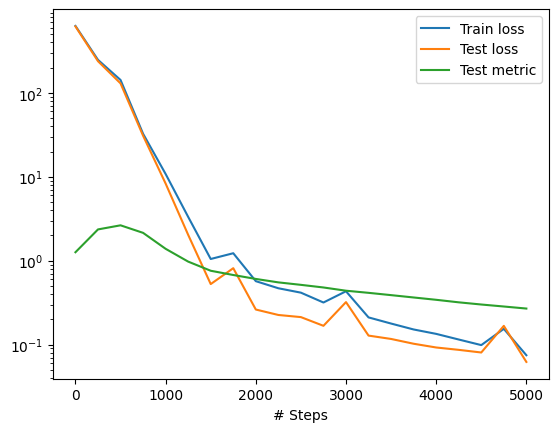

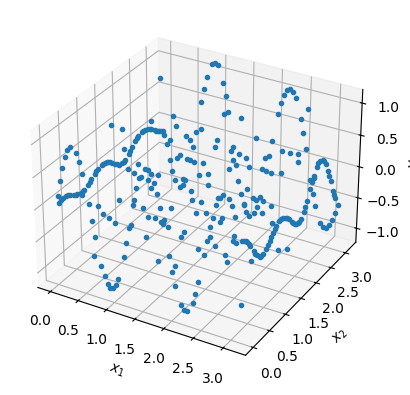

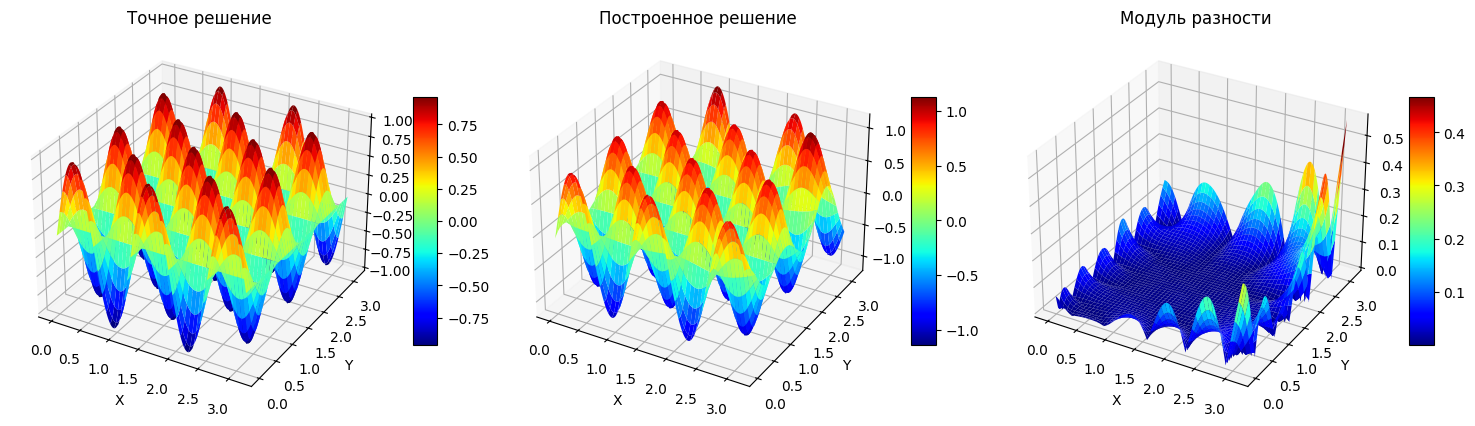

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\gameh\AppData\Local\Temp\ipykernel_7440\186357564.py:101: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return cs.collections


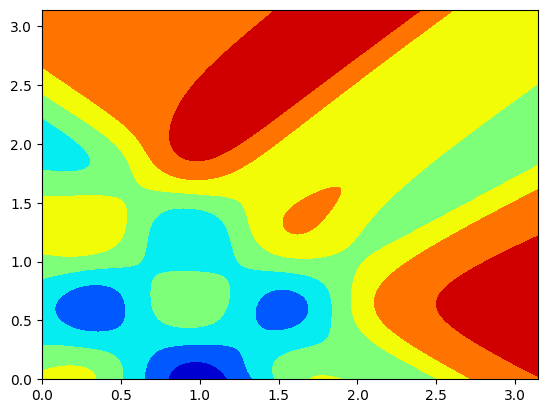

In [51]:
poisson_pinn(5000)

In [9]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=2000, num_boundary=200, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model.train(iterations=N)

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 1000), np.linspace(0, np.pi, 1000))
    X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T

    u_pred = model.predict(X_test_flat).reshape(X_test.shape)

    u_exact_vals = u_exact(X_test, Y_test)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('auto')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()
    
    np.savez("solution_deepxde.npz", X=X_test, Y=Y_test, u=u_pred)

Compiling model...
'compile' took 0.002431 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.07e+00, 6.27e-01]    [1.05e+00, 6.27e-01]    [1.52e+00]    
1000      [5.24e-04, 1.73e-04]    [3.46e-04, 1.73e-04]    [2.21e-02]    
2000      [1.93e-04, 8.61e-05]    [1.31e-04, 8.61e-05]    [1.55e-02]    
3000      [1.16e-04, 4.91e-05]    [8.03e-05, 4.91e-05]    [1.16e-02]    
4000      [8.16e-05, 3.23e-05]    [5.75e-05, 3.23e-05]    [9.44e-03]    
5000      [6.38e-05, 3.01e-05]    [5.04e-05, 3.01e-05]    [9.13e-03]    

Best model at step 5000:
  train loss: 9.39e-05
  test loss: 8.05e-05
  test metric: [9.13e-03]

'train' took 27.046742 s

Saving loss history to c:\Users\gameh\Documents\codes\kt_matmodel_2025\Task_1\loss.dat ...
Saving training data to c:\Users\gameh\Documents\codes\kt_matmodel_2025\Task_1\train.dat ...
Saving test data to c:\Users\gameh\Documents\codes\kt_matmodel_2025\Task_1\test.dat ...


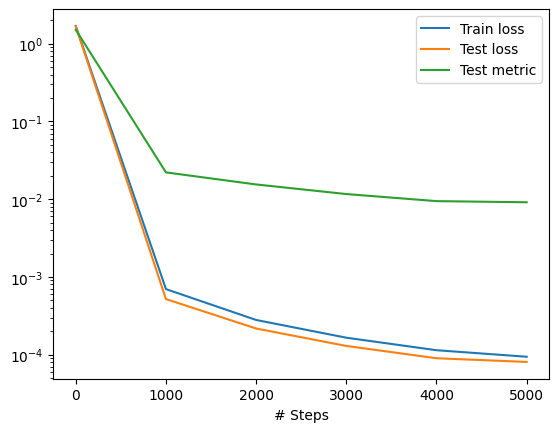

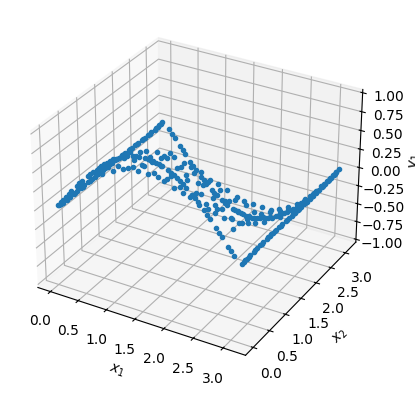

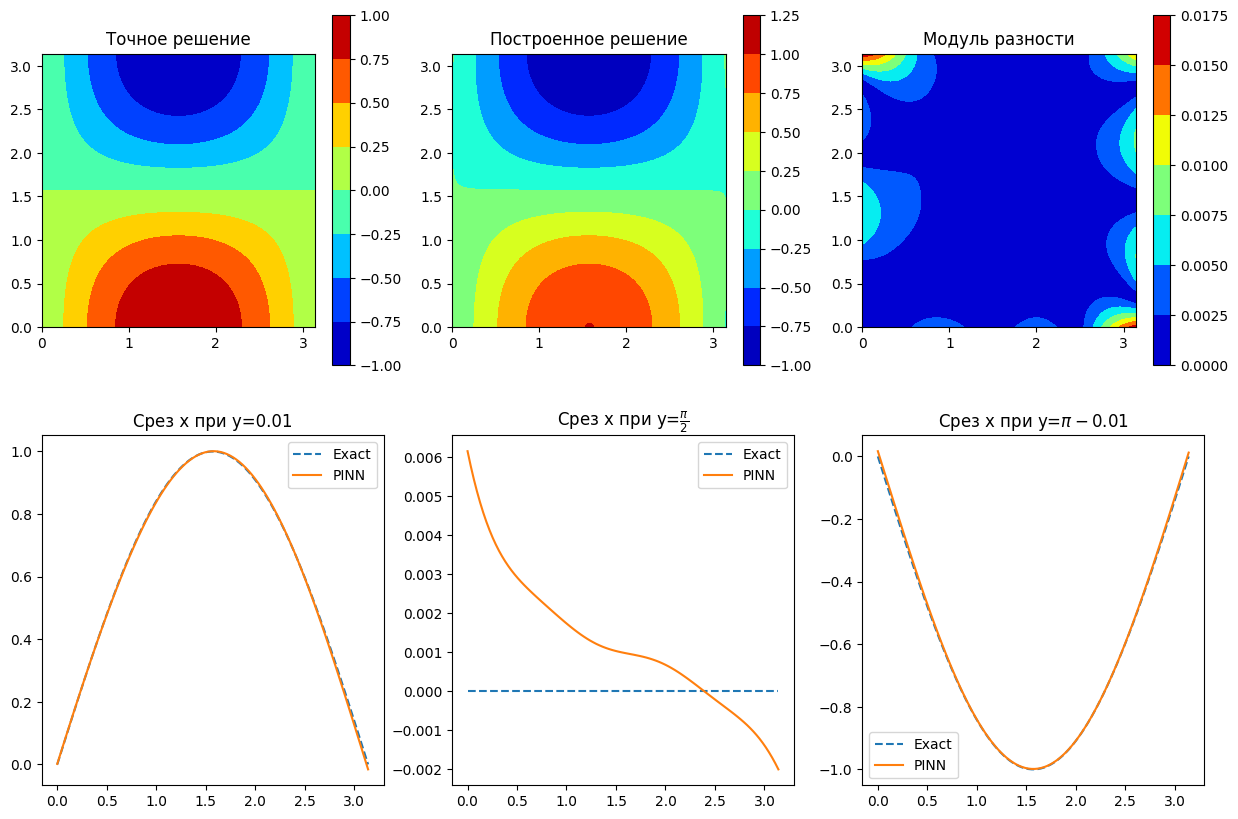

In [31]:
poisson_pinn(5000)

Compiling model...
'compile' took 0.002685 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.40e+03, 4.25e-01]    [2.38e+03, 4.25e-01]    [1.25e+00]    
1000      [4.89e+02, 2.13e+00]    [5.63e+02, 2.13e+00]    [2.83e+00]    
2000      [1.24e+02, 1.73e+00]    [1.15e+02, 1.73e+00]    [2.31e+00]    
3000      [6.21e+00, 8.68e-01]    [6.86e+00, 8.68e-01]    [1.57e+00]    
4000      [2.44e+00, 4.93e-01]    [1.83e+00, 4.93e-01]    [1.18e+00]    
5000      [1.54e+00, 3.30e-01]    [1.02e+00, 3.30e-01]    [9.62e-01]    
6000      [1.17e+00, 2.42e-01]    [8.63e-01, 2.42e-01]    [8.22e-01]    
7000      [9.98e-01, 1.87e-01]    [7.55e-01, 1.87e-01]    [7.23e-01]    
8000      [7.18e-01, 1.47e-01]    [4.22e-01, 1.47e-01]    [6.40e-01]    
9000      [5.26e-01, 1.15e-01]    [3.21e-01, 1.15e-01]    [5.66e-01]    
10000     [5.42e-01, 9.03e-02]    [3.74e-01, 9.03e-02]    [5.01e-01]    

Best model at step 10000:
  train loss: 6.32e-01
  test lo

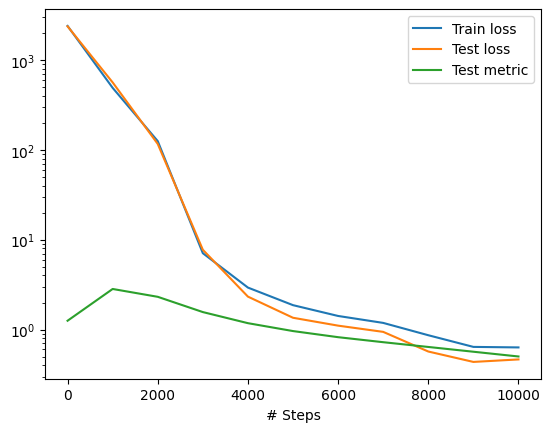

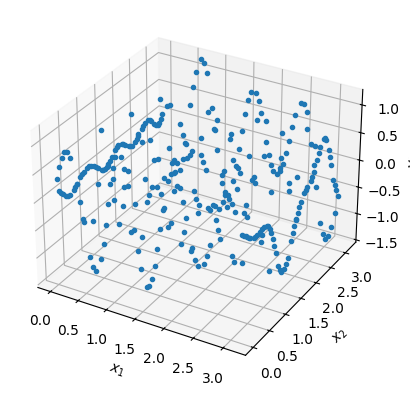

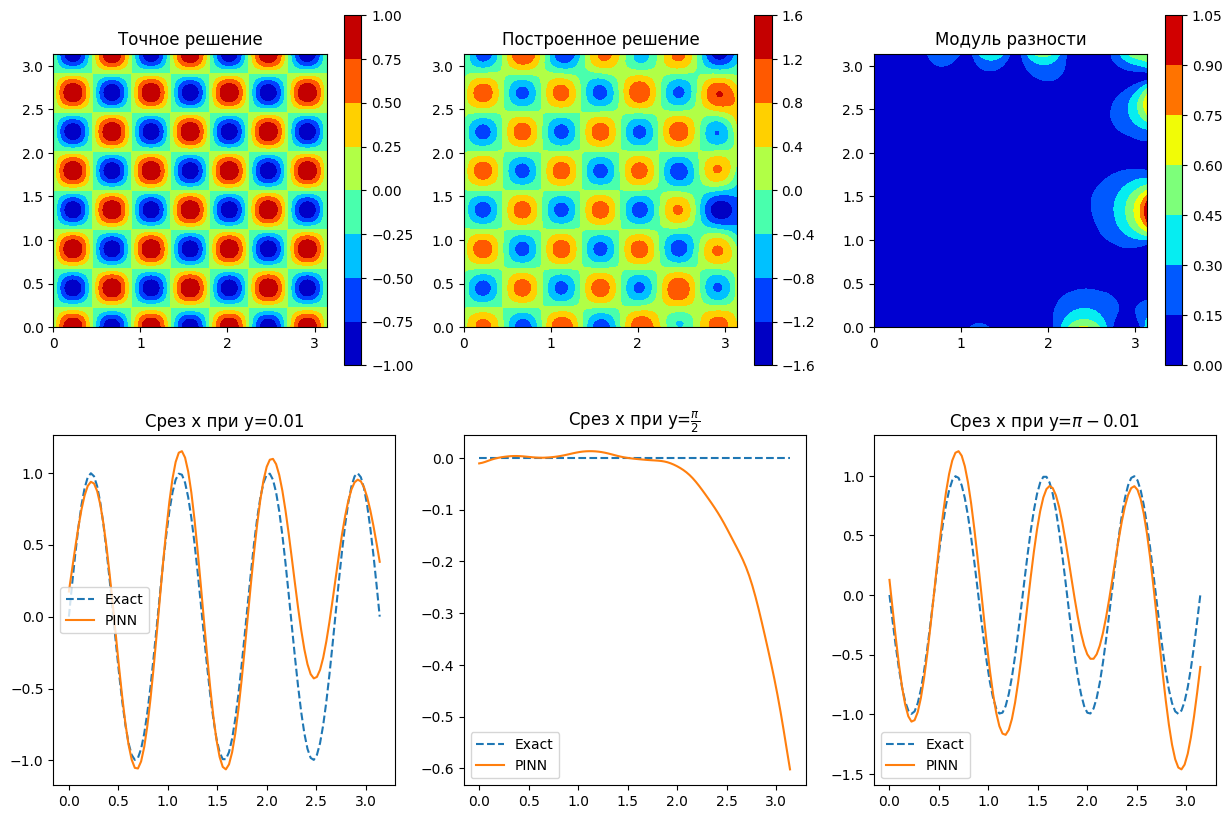

In [33]:
poisson_pinn(10000)

Compiling model...
'compile' took 0.026908 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.00e+04, 3.55e-01]    [9.90e+03, 3.55e-01]    [1.18e+00]    
1000      [6.29e+03, 3.80e+00]    [7.74e+03, 3.80e+00]    [3.54e+00]    
2000      [4.51e+03, 2.14e+01]    [6.04e+03, 2.14e+01]    [8.34e+00]    
3000      [3.86e+03, 1.98e+01]    [5.23e+03, 1.98e+01]    [7.97e+00]    
4000      [3.41e+03, 2.28e+01]    [4.64e+03, 2.28e+01]    [8.42e+00]    
5000      [3.14e+03, 3.16e+01]    [4.12e+03, 3.16e+01]    [9.85e+00]    
6000      [3.02e+03, 3.32e+01]    [4.12e+03, 3.32e+01]    [1.01e+01]    
7000      [2.89e+03, 3.08e+01]    [4.51e+03, 3.08e+01]    [9.62e+00]    
8000      [2.82e+03, 2.69e+01]    [4.31e+03, 2.69e+01]    [8.93e+00]    
9000      [2.78e+03, 2.50e+01]    [4.13e+03, 2.50e+01]    [8.55e+00]    
10000     [2.71e+03, 2.42e+01]    [4.16e+03, 2.42e+01]    [8.35e+00]    
11000     [2.62e+03, 2.20e+01]    [3.98e+03, 2.20e+01]    [

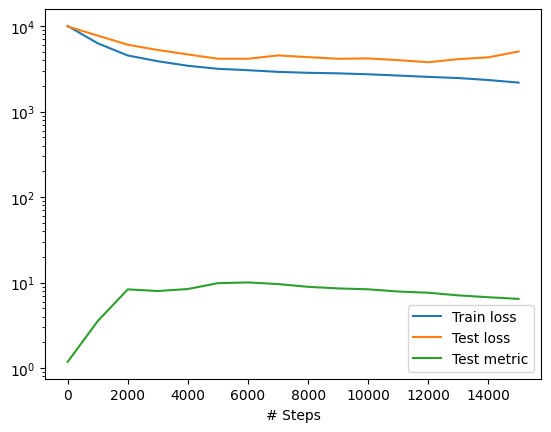

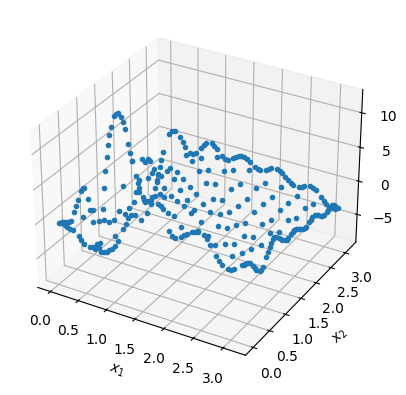

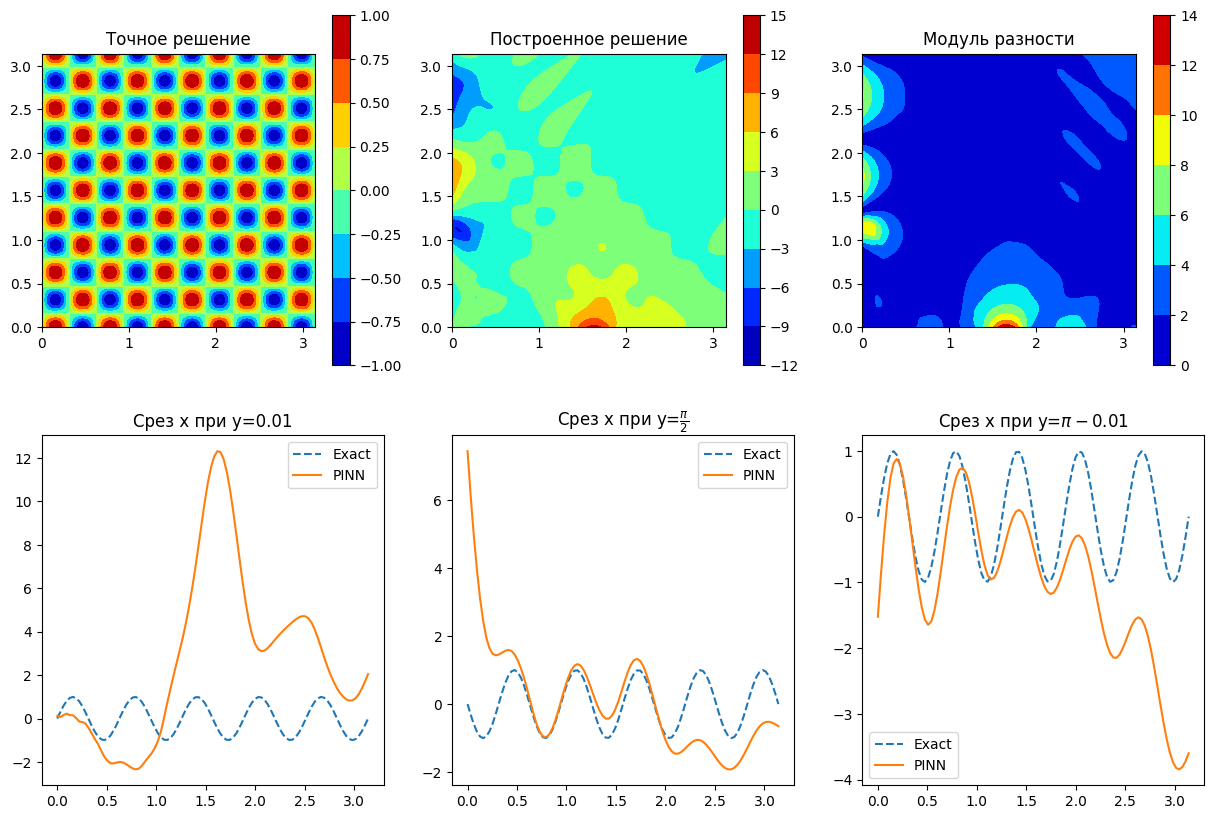

In [11]:
poisson_pinn(15000)

In [12]:
def poisson_pinn(N):
    geom = dde.geometry.Rectangle([0, 0], [np.pi, np.pi])
    bc = dde.DirichletBC(geom, g, boundary_condition)
    data = dde.data.PDE(geom, pde, [bc], num_domain=1000, num_boundary=100, solution=func, num_test=100)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    
    u_pred_list = []
    for i in range(0, N+1, 500):
        model.train(iterations=i, display_every=500)
        X_test, Y_test = np.meshgrid(np.linspace(0, np.pi, 100), np.linspace(0, np.pi, 100))
        X_test_flat = np.vstack([X_test.ravel(), Y_test.ravel()]).T
        u_pred = model.predict(X_test_flat).reshape(X_test.shape)
        u_pred_list.append(u_pred)
    
    u_exact_vals = u_exact(X_test, Y_test)
    
    l2_error, c_error = compute_error_metrics(u_pred, u_exact_vals)
    l2_residual, c_residual = compute_residual_norm(model, X_test_flat)
    
    print(f"L2 error: {l2_error}, C error: {c_error}")
    print(f"L2 residual norm: {l2_residual}, C residual norm: {c_residual}")
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    cs1 = axs[0, 0].contourf(X_test, Y_test, u_exact_vals, cmap="jet")
    axs[0, 0].set_aspect('equal')
    fig.colorbar(cs1, ax=axs[0, 0])
    axs[0, 0].set_title("Точное решение")
    
    cs2 = axs[0, 1].contourf(X_test, Y_test, u_pred, cmap="jet")
    fig.colorbar(cs2, ax=axs[0, 1])
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_title("Построенное решение")
    
    cs3 = axs[0, 2].contourf(X_test, Y_test, np.abs(u_pred - u_exact_vals), cmap="jet")
    fig.colorbar(cs3, ax=axs[0, 2])
    axs[0, 2].set_aspect('equal')
    axs[0, 2].set_title("Модуль разности")
    
    x_slice = np.linspace(0, np.pi, 100)
    y_values = [0.01, np.pi / 2, np.pi - 0.01]
    y_values_names = ['0.01', '$\\frac{\pi}{2}$', '$\pi - 0.01$']
    
    for i, y in enumerate(y_values):
        xy_slice = np.vstack([x_slice, y * np.ones_like(x_slice)]).T
        u_exact_slice = u_exact(x_slice, y)
        u_pred_slice = model.predict(xy_slice)
        axs[1, i].set_aspect('equal')
        axs[1, i].plot(x_slice, u_exact_slice, label="Exact", linestyle="--")
        axs[1, i].plot(x_slice, u_pred_slice, label="PINN")
        axs[1, i].legend()
        axs[1, i].set_title("Срез x при y=" + y_values_names[i])
    
    plt.show()
    
    fig_anim, ax_anim = plt.subplots()
    def update_anim(frame):
        ax_anim.clear()
        cs = ax_anim.contourf(X_test, Y_test, u_pred_list[frame], cmap="jet")
        return cs.collections
    
    ani = animation.FuncAnimation(fig_anim, update_anim, frames=len(u_pred_list), interval=200)
    ani.save("pinn_solution_evolution.gif", writer="ffmpeg")
    
    return l2_error, c_error, l2_residual, c_residual

poisson_pinn(5000)

Compiling model...
'compile' took 0.002803 s

Training model...

0         [1.33e-01, 2.89e-01]    [1.72e-01, 2.89e-01]    [2.32e+00]    

Best model at step 0:
  train loss: 4.22e-01
  test loss: 4.61e-01
  test metric: [2.32e+00]

'train' took 0.437227 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.33e-01, 2.89e-01]    [1.72e-01, 2.89e-01]    [2.32e+00]    
500       [4.07e-03, 2.73e-03]    [2.76e-03, 2.73e-03]    [2.02e-01]    

Best model at step 500:
  train loss: 6.80e-03
  test loss: 5.49e-03
  test metric: [2.02e-01]

'train' took 2.278452 s

Training model...

Step      Train loss              Test loss               Test metric   
500       [4.07e-03, 2.73e-03]    [2.76e-03, 2.73e-03]    [2.02e-01]    


KeyboardInterrupt: 